### RAG implementation using the sentence-window-retrieval technique with LlamaIndex and TrueLens for evaluating the application. 

In this method, we retrieve based on smaller sentences to get a better match for the retrieval context and then synthesize based on the expanded context window around the sentence. 

Import all necessary libraries.


In [4]:
import os 
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
model = "gpt-4o-mini"

In [5]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader

docs = SimpleDirectoryReader("data").load_data()
index = VectorStoreIndex.from_documents(docs)
query_engine = index.as_query_engine()
response = query_engine.query('What is a transformer?')
print(response)

A Transformer is a model architecture that relies entirely on an attention mechanism to draw global dependencies between input and output, without using recurrence. It allows for significantly more parallelization compared to recurrent models, making it possible to achieve state-of-the-art results in tasks like translation with reduced training time.


Now, we are using another model Mistal-7B, which is an open-source model.

In [ ]:
import torch 

from llama_index.llms import LlamaCPP
from llama_index.llms.llama_utils import messages_to_prompt, completion_to_prompt 

llm = LlamaCPP(
    model_url='https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/blob/main/mistral-7b-instruct-v0.2.Q8_0.gguf',
    model_path=None,
    temperature=0.1,
    max_new_tokens=256,
    context_window=4096,
    generate_kwargs={},
    model_kwargs={"n_gpu_layers": 1},
    messages_to_prompt=messages_to_prompt,
    completion_to_prompt=completion_to_prompt,
    verbose=True,
)

We read the document from the directory and concatenate each page of the document into a single object.

In [ ]:
from llama_index import Document 

docs = SimpleDirectoryReader("data").load_data()
docs = Document(text="\n\n".join([doc.text for doc in docs]))

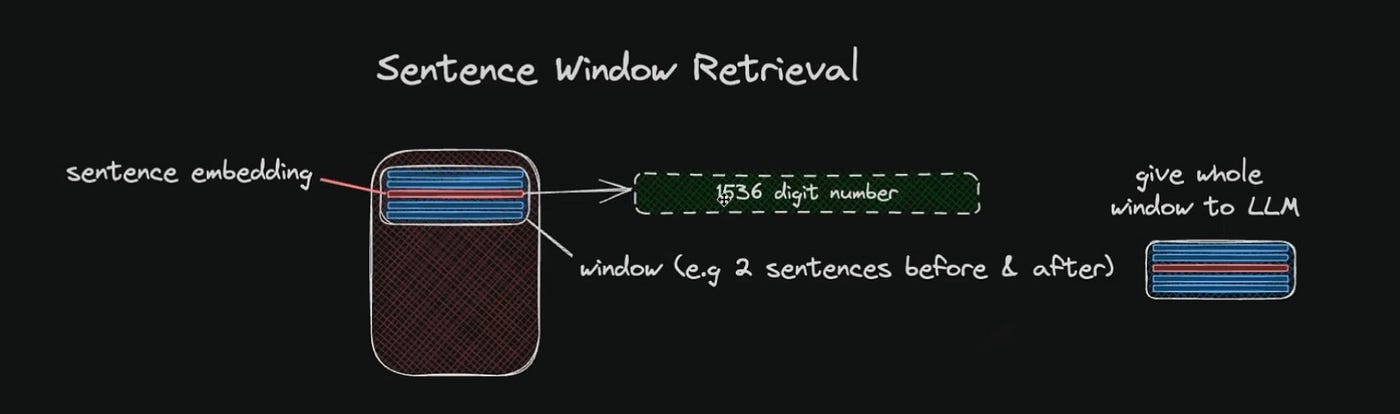

In [ ]:
from llama_index.node_parser import SentenceWindowNodeParser
from llama_index import ServiceContext, load_index_from_storage

def get_build_index(documents,llm,embed_model="local:BAAI/bge-small-en-v1.5",sentence_window_size=3,save_dir="./vector_store/index"):
  
  node_parser = SentenceWindowNodeParser(
      window_size = sentence_window_size,
      window_metadata_key = "window",
      original_text_metadata_key = "original_text"
  )

  sentence_context = ServiceContext.from_defaults(
      llm = llm,
      embed_model= embed_model,
      node_parser = node_parser,
  )

  if not os.path.exists(save_dir):
        # create and load the index
        index = VectorStoreIndex.from_documents(
            [documents], service_context=sentence_context
        )
        index.storage_context.persist(persist_dir=save_dir)
  else:
      # load the existing index
      index = load_index_from_storage(
          StorageContext.from_defaults(persist_dir=save_dir),
          service_context=sentence_context,
      )

  return index

In [ ]:
# Vector store index
vector_index = get_build_index(documents=documents, llm=llm, embed_model="local:BAAI/bge-small-en-v1.5", sentence_window_size=3, save_dir="./vector_store/index")

The above function creates the query engine for the newly created vector index. It is possible to query every document using that query engine. 

In [ ]:
from llama_index.core.postprocessor import MetadataReplacementPostProcessor, SentenceTransformerRerank

def get_query_engine(sentence_index, similarity_top_k=6, rerank_top_n=2):
    postproc = MetadataReplacementPostProcessor(target_metadata_key="window")
    rerank = SentenceTransformerRerank(
        top_n=rerank_top_n, model="BAAI/bge-reranker-base"
    )
    engine = sentence_index.as_query_engine(
            similarity_top_k=similarity_top_k, node_postprocessors=[postproc, rerank]
    )

    return engine

In [ ]:
query_engine = get_query_engine(sentence_index=vector_index, similarity_top_k=6, rerank_top_n=2)

The RAG pipeline is ready to response.

In [ ]:
while True:
  query=input()
  response = query_engine.query(query)
  display_response(response)
  print("\n")